## CSSE4011 - Kalman Filter Tracking Lab
The goal of this lab is to define a Kalman filter for tracking an object in 2D space and to learn about the different Kalman filter parameters that we can tweak to change Kalman Filters performance. 

We start with recapping the key Kalman Filter concepts.

### Kalman Filter Definition
We first define Kalman filter for tracking objects that move at a constant velocity in a 2-dimensional space. 

#### State vector
We would like the filter to track four state variables - location and velocity vector of the object. The state vector is then defined as follows
> $[x,y,v_x,v_y]$

where $x$ and $y$ are location of the object and $v_x$ and $v_y$ are the velocity vector

#### Transition Matrix $F$
Next we define the state transition matrix $F$ that defines how the state vector changes over time. Given time interval $dt$ (e.g., 1 second), position $x$ will increase by $x+v_x*dt$ and position $y$ will increase by $y+v_y*dt$
 >   <table >
 >   <tr><th> x </th><th> x </th><th> x </th><th>   x </tr>
 >   <tr><th> x </th><th> x </th><th> x  </th><th>  x </tr>
 >   <tr><th> x </th><th> x </th><th> x  </th><th>  x </tr>
 >   <tr><th> x </th><th> x </th><th> x  </th><th>  x </tr>
 >   </table>


#### Observation Matrix $H$
The observation matrix $H$ specifies the relationships between measurements and the state vector. We assume we have a sensor that can directly observe location $(x,y)$ of the tracked object (e.g., GPS or a multi-lateration method).
>    <table >
>    <tr><th> x </th><th> x </th><th> x </th><th> x </tr>
>    <tr><th> x </th><th> x </th><th> x </th><th> x </tr>
>    </table>

#### Error Matrices $Q$ and $R$

Process noise matrix $Q$ expresses our confidence in the state transition matrix $F$. In other words, how confident are we that the tracked object will follow the prescribed process, such as, infinite constant-speed linear motion. For simplicity, we assume that position and velocity are uncorrelated and use a parameter <b>proc_error</b> to control the magnitude of the process error.

> $Q = eye(4)*proc_-error$

Measuremetn noise matrix $R$ expresses our confidence in the measurements. For simplicity, we assume a constant measurement error the magnitude of which is controlled through <b>meas_error</b> parameter.
> $R = eye(2)*meas_-error$


## Simulation
Now lets prepare a simulation of an object moving through 2-dimensional space!

We first define a function that will generate a simulated trajectory assuming linear motion with velocity vector (v<sub>x</sub>,v<sub>y</sub> ), for <b>num_steps</b> number of simualted steps, assuming each step takes <b>dt</b> seconds. Remember, state vector defined above has four parameters, as it tracks both location and velocity.

### Generate Simulated Data

Now we generated the data. Let's assume we have 100 steps in our simulation and each step takes dt = 1 second. Let's assume our object starts at $[5,2]$ location and is moving with velocity vetor $[1,2]$. You can imagine the location units are in meters and velocity units are in meters per second.

Let's also assume our measurement error is pretty poor - makes an average erorr of 10m.

The code below generates the ground truth state vector for the tracked object (<b>x_true</b>) and also generates a measurement error vector (<b>obs_err</b>) by drawing errors randomly from a normal (Gaussian) distribution with mean defined by the <b>meas_error</b> parameter. We add the two vectors to obtain the observation vector (<b>obs</b>) for each timestamp.

Finally, plot the ground truth and measured location data.

/var/folders/4x/5ybxtpbn6t95rpf4t1qwxvc000_4nq/T/ipykernel_76587/1333417152.py:29: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(obs[:,0],   obs[:,1],   s=10,c='k',marker='+', edgecolors='k', label="measured loc")


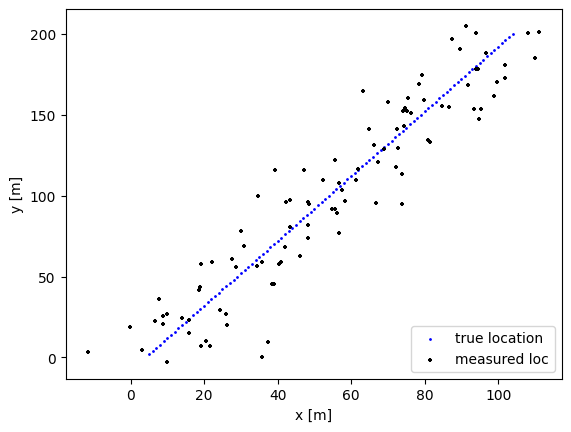

In [1]:
import matplotlib.pyplot as plt
import numpy
import random

def generate_trajectory(x,y,vx,vy,dt,num_steps):
    return [(x+i*dt*vx,
             y+i*dt*vy) for i in range(num_steps)]

dim_x = 4
dim_z = 2

nsteps = 100
dt = 1.0 #sec
xcoord = 5.0
ycoord = 2.0
vx = 1.0 #m.s
vy = 2.0 #m/s
meas_error = 10.0 #m

#generate ground truth
x_true = numpy.array(generate_trajectory(xcoord,ycoord,vx,vy,dt,nsteps))
obs_err = numpy.random.normal(0,numpy.ones(dim_z)*meas_error,(nsteps,dim_z)) # observations 
obs = x_true[:,0:2]+obs_err

plt.figure()
plt.scatter(x_true[:,0],x_true[:,1],s=1, c='b',marker='o', edgecolors='b', label="true location")
plt.scatter(obs[:,0],   obs[:,1],   s=10,c='k',marker='+', edgecolors='k', label="measured loc")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(loc=4)

## Track Object Location
The final step is to use the Kalman filter to track location of the object given the noisy measurements. 

We use heuristic values for Kalman Filter parameters that can be found in literature or are derived from the real-world constraints in the specific tracking scenario. 
-  we use process error value of 1
-  we estimate inital error to be within a 10m^2 area
-  the measurement error is typically estimated by characterizing the measurement method, here we use the true measurement error that we used in the simulator above.

### Exercise 1: Define the Tracker 
Define the Kalman Filter matrices as per the definitions above, using the filterpy python library. 

After the filter is defined, run it to predict the tracked object locations. You can use batch_filter function to predict the location for the whole observation vector. For real-time tracking, you'd run predict and update functions of the kalman filter library.

In [2]:
from filterpy.kalman import KalmanFilter

proc_error = 1e-0
init_error = 10.0

x_init = numpy.array( [xcoord+random.uniform(-init_error/2,init_error/2), ycoord+random.uniform(-init_error/2,init_error/2), vx, vy] ) #introduced initial xcoord error of 10m 
cov_init=init_error**2 * numpy.eye(dim_x)

kf = KalmanFilter(dim_x, dim_z)
kf.F = numpy.array(?)
kf.Q = numpy.eye(dim_x)*proc_error
kf.H = numpy.array(?)
kf.R = numpy.eye(dim_z)*meas_error

kf.x = x_init.T
kf.P = cov_init

#track the object (use batch mode to calculate predictions for the whole simulation vector obs)
x_pred, cov, _, _ = kf.batch_filter(obs)

plt.figure()
plt.scatter(x_true[:,0],x_true[:,1],s=1, c='b',marker='o', edgecolors='b', label="true location")
plt.scatter(obs[:,0],   obs[:,1],   s=10,c='k',marker='+', edgecolors='k', label="measured loc")
plt.scatter(x_pred[:,0], x_pred[:,1], s=10,c='r',marker='s', edgecolors='r', label="estimated loc")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(loc=4)

SyntaxError: invalid syntax (2044379251.py, line 10)

### Exercise 2 - improve KF performance by tweaking the error matrices
Kalman filter performance depends on how well we estimated the uncertainties that are present in the model. Note we have made a number of simplifying assumtions and it's always a good practice to study how well the algorithm works when a hyper-parameter value changes. In this exercise, tweak the value of <b>proc_error</b> function to get a smoother predicted trajectory.

In [3]:
proc_error = 1e-0
kf.Q = numpy.eye(dim_x)*proc_error

kf.x = x_init.T
kf.P = cov_init
x_pred, cov, _, _ = kf.batch_filter(obs)

plt.figure()
plt.scatter(x_true[:,0],x_true[:,1],s=1, c='b',marker='o', edgecolors='b', label="true location")
plt.scatter(obs[:,0],   obs[:,1],   s=10,c='k',marker='+', edgecolors='k', label="measured loc")
plt.scatter(x_pred[:,0], x_pred[:,1], s=10,c='r',marker='s', edgecolors='r', label="estimated loc")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(loc=4)

NameError: name 'kf' is not defined

### Exercise 3 - parameter value tradeoffs in different scenarios
In the previous exercise, you have tweaked the proc_error parameter to get smoother predicted trajectory, relying on the assumption that the process is very stable, ie, the object moves in linear fashion during the trajectory.

What happens if this assumption changes, for example, if object moves in a piece-wise linear fashion?

What happens if the assumption of the measurement error being from a Gaussian distribution is not valid and we encounter one corrupted sample?

What are the trade-offs that the different values of the proc_error parameter offer?

In [4]:
xt1 = generate_trajectory(xcoord,ycoord,vx,vy,dt,int(nsteps/4))
xt2 = generate_trajectory(xt1[-1][0],xt1[-1][1],-vx,vy,dt,int(nsteps/4))
xt3 = generate_trajectory(xt2[-1][0],xt2[-1][1],-vx,-vy,dt,int(nsteps/4))
xt4 = generate_trajectory(xt3[-1][0],xt3[-1][1],-vx,vy,dt,int(nsteps/4))
x_true = numpy.array(xt1+xt2+xt3+xt4)
obs_err = numpy.random.normal(0,numpy.ones(dim_z)*meas_error,(nsteps,dim_z)) # observations 
obs = x_true[:,0:2]+obs_err

proc_error = 1e-5
kf.Q = numpy.eye(dim_x)*proc_error

kf.x = x_init.T
kf.P = cov_init
x_pred, cov, _, _ = kf.batch_filter(obs)

plt.figure()
plt.scatter(x_true[:,0],x_true[:,1],s=1, c='b',marker='o', edgecolors='b', label="true location")
plt.scatter(obs[:,0],   obs[:,1],   s=10,c='k',marker='+', edgecolors='k', label="measured loc")
plt.scatter(x_pred[:,0], x_pred[:,1], s=10,c='r',marker='s', edgecolors='r', label="estimated loc")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(loc=4)

NameError: name 'kf' is not defined

In [5]:
x_true = numpy.array(generate_trajectory(xcoord,ycoord,vx,vy,dt,nsteps))
obs_err = numpy.random.normal(0,numpy.ones(dim_z)*meas_error,(nsteps,dim_z)) # observations 
obs = x_true[:,0:2]+obs_err
obs[50,:]+=(1000,0)

proc_error = 1e-5
kf.Q = numpy.eye(dim_x)*proc_error

kf.x = x_init.T
kf.P = cov_init
x_pred, cov, _, _ = kf.batch_filter(obs)

plt.figure()
plt.scatter(x_true[:,0],x_true[:,1],s=1, c='b',marker='o', edgecolors='b', label="true location")
plt.scatter(obs[:,0],   obs[:,1],   s=10,c='k',marker='+', edgecolors='k', label="measured loc")
plt.scatter(x_pred[:,0], x_pred[:,1], s=10,c='r',marker='s', edgecolors='r', label="estimated loc")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(loc=4)

NameError: name 'kf' is not defined

### Exercise 4 - more advanced trajectories

How is your filter performing for non-linear trajectories? Can you change the simulator to generate a circular path? 

Are you able to tweak parameters of the linear motion KF model to approimate the trajectory well?

Can you extend the filter with a complete physical model including acceleration? Has the prediction performance improved?

In [ ]:
import math
def generate_trajectory(x,y,num_steps):
    return [(?,?) for angle in numpy.arange(0.0,6.28,6.28/num_steps)]

meas_error = 10.0 #m
nsteps=500

x_true = numpy.array(generate_trajectory(xcoord,ycoord,nsteps))
obs_err = numpy.random.normal(0,numpy.ones(dim_z)*meas_error,(nsteps,dim_z)) # observations 
obs = x_true[:,0:2]+obs_err

proc_error = 1e-5
init_error = 10.0

dim_x=6
x_init = numpy.array( [xcoord+random.uniform(-init_error/2,init_error/2), ycoord+random.uniform(-init_error/2,init_error/2), vx, vy, 0, 0] )
cov_init=100*init_error**2 * numpy.eye(dim_x)
kf = KalmanFilter(dim_x, dim_z)
kf.F = numpy.array([?])
kf.Q = numpy.eye(dim_x)*proc_error
kf.H = numpy.array([(1, 0, 0, 0,0,0), (0, 1, 0, 0,0,0)])
kf.R = numpy.eye(dim_z)*meas_error


kf.x = x_init.T
kf.P = cov_init

x_pred, cov, _, _ = kf.batch_filter(obs)

plt.figure()
plt.scatter(x_true[:,0],x_true[:,1],s=1, c='b',marker='o', edgecolors='b', label="true location")
plt.scatter(obs[:,0],   obs[:,1],   s=10,c='k',marker='+', edgecolors='k', label="measured loc")
plt.scatter(x_pred[:,0], x_pred[:,1], s=10,c='r',marker='s', edgecolors='r', label="estimated loc")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(loc=4)